In [1]:
import sys,os
import numpy as np
import pandas as pd
import random

sys.path.append('../')

from unpast.utils.method import prepare_input_matrix
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.consensus import make_consensus_biclusters
from unpast.run_unpast import unpast

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
passed_ids = pd.read_csv("../../data/preprocessed_v6/passed_gene_ids.txt",header=None)
passed_ids = passed_ids[0].values
passed_ids = [ x for x in sorted(set(passed_ids)) if not x =='pk' ]
bic_dir = "../../all_cancers_results_latest/"
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"

exprs_dir = "../../data/PanCan/"
len(passed_ids)

26296

In [3]:
analysis_seed = 0
n_runs = 5
seeds = []
random.seed(analysis_seed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))

print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


# Runnig UnPaSt five times and making consensus for each cancer
(time-consuming)

In [ ]:
# running UnPaST for each cancer (time consuming)
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz") and f.replace(".exprs.tsv.gz",""): # 
        cancer = f.replace(".exprs.tsv.gz","")
        
        exprs_file = cancer+".exprs.tsv.gz"
        exprs = pd.read_csv(exprs_dir+"/"+exprs_file,sep = "\t",index_col=0)

        exprs = exprs.loc[passed_ids,:]
        exprs.to_csv(exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz", sep = "\t")
        basename = cancer
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        
        print(cancer, exprs_file, exprs.shape)
        for seed in seeds:
            results = unpast(exprs_file, basename,
                                  rpath="/home/olya/anaconda3/envs/r4_env/bin/",
                                  out_dir=bic_dir,
                                  load=False,
                                  seed = seed,
                                  verbose = False)

            print("\tn=%s"%results.shape[0])

In [ ]:
# reading UnPaSt results and making consensus biclusters
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz") and f.replace(".exprs.tsv.gz",""): # 
        cancer = f.replace(".exprs.tsv.gz","")
        
        basename = cancer
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
        exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)

        biclusters = []
        for seed in seeds:
            bic_file = bic_dir+cancer+".seed="+str(seed)+suffix
            b = read_bic_table(bic_file)
            b.index = ["seed="+str(seed)+"_"+str(x) for x in b.index.values ]
            biclusters.append(b)
        cb = make_consensus_biclusters(biclusters,
                                       exprs_z,
                                       seed = analysis_seed,
                                       verbose = True,
                                       plot = False
                                      )
        cb.index = [cancer+"_"+str(x) for x in cb.index.values]
        write_bic_table(cb, bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix)
        print(cancer, cb.shape[0], exprs.shape)

# Reading consensus biclusters and expressions  for each cancer

In [4]:
stats = {}
bics = {}
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz"): # 
        cancer = f.replace(".exprs.tsv.gz","")
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
        b = read_bic_table(bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix)
        b["cancer"] = cancer
        bics[cancer] = b
        #print(cancer, exprs.shape[1],b.shape[0])
        stats[cancer] = {"n_samples":exprs.shape[1],
                         "n_biclusters":b.shape[0]}
stats = pd.DataFrame.from_dict(stats).T

In [5]:
# https://cancerci.biomedcentral.com/articles/10.1186/s12935-020-01678-x/figures/2
ecto = ["BRCA","HNSC","GBM","LGG","SKCM","PCPG","UVM"]
meso=["OV","PRAD","LAML","DLBC","UCS","UCEC",
      "KICH","KIRC","KIRP","MESO","TGCT","SARC",
     "CESC","ACC"]
# ? ESCA -? Esophageal carcinoma
ento=["READ","COAD","LUAD","LUSC","THYM","THCA","STAD",
      "PAAD","LIHC","BLCA","CHOL",]

stats["germ_layer"] = ""
stats.loc[ecto,"germ_layer"] = "ecto"
stats.loc[meso,"germ_layer"] = "meso"
stats.loc[ento,"germ_layer"] = "ento"
stats

,n_samples,n_biclusters,germ_layer
ACC,77,1270,meso
BLCA,407,872,ento
BRCA,1098,285,ecto
CESC,306,484,meso
CHOL,36,504,ento
COAD,288,275,ento
DLBC,47,472,meso
ESCA,182,400,
GBM,165,1289,ecto
HNSC,520,495,ecto


<Figure size 500x500 with 0 Axes>

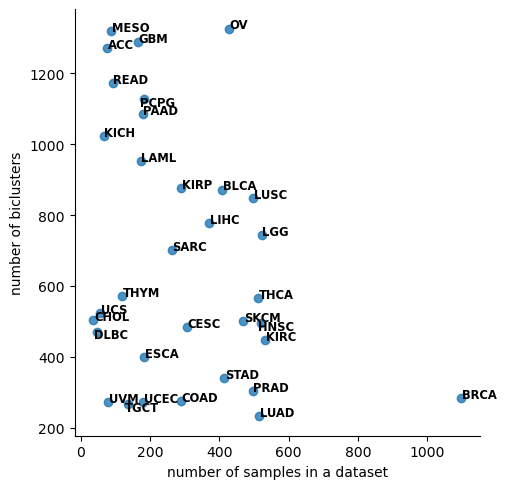

In [6]:
plt.figure(figsize=(5,5))

stats["cancer"]=stats.index
sns.lmplot(data=stats, 
           x="n_samples",
           y="n_biclusters",
           fit_reg=False)#, hue='germ_layer')

for line in range(0,stats.shape[0]):
    if stats.index[line] not in ["PCPG","DLBC","HNSC","TGCT"]:
        plt.text(stats.n_samples[line]+2, stats.n_biclusters[line],
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
    else:
        plt.text(stats.n_samples[line]-10, stats.n_biclusters[line]-20,
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')

plt.xlabel("number of samples in a dataset")
plt.ylabel("number of biclusters")
plt.savefig(bic_dir+"/bic_number_vs_sample_size.svg")
plt.show()

In [7]:
from scipy.stats import pearsonr
pearsonr(stats["n_samples"].values, stats["n_biclusters"].values)

PearsonRResult(statistic=-0.3059645833445408, pvalue=0.08333334927553021)

In [8]:
# without BRCA
pearsonr(stats.loc[stats["cancer"]!="BRCA","n_samples"].values,
        stats.loc[stats["cancer"]!="BRCA","n_biclusters"].values)

PearsonRResult(statistic=-0.2358045536151381, pvalue=0.19385712226003962)

### Average pairwise correlation

In [9]:
stats["avg_corr"] = 0
stats_corr = {}
for cancer in stats.index.values:
    #print(cancer)
    avg_corrs = []
    exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
    exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
    exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
    for bic_id in bics[cancer].index:
        genes = bics[cancer].loc[bic_id,"genes"]
        e = exprs_z.loc[list(genes),:]
        n = len(genes)
        avg_corr = np.abs(np.triu(e.T.corr(),k=1)).sum().sum()*2/(n**2-n)
        avg_corrs.append(avg_corr)
        stats_corr[bic_id] = { "cancer":cancer,
                                "n_genes":len(genes),
                                "n_samples": bics[cancer].loc[bic_id,"n_samples"],
                                "SNR": bics[cancer].loc[bic_id,"SNR"],
                                "avg_corr": avg_corr}
    stats.loc[cancer,"avg_corr"] = np.mean(avg_corrs)
stats_corr  = pd.DataFrame.from_dict(stats_corr ).T
stats_corr

,cancer,n_genes,n_samples,SNR,avg_corr
ACC_0,ACC,4,7,4.189811,0.472651
ACC_1,ACC,2,6,4.067015,0.718106
ACC_2,ACC,2,10,4.026932,0.339168
ACC_3,ACC,3,6,3.858772,0.629171
ACC_4,ACC,3,7,3.734821,0.301432
...,...,...,...,...,...
UVM_269,UVM,5,27,1.362595,0.312578
UVM_270,UVM,11,16,1.326295,0.240575
UVM_271,UVM,3,15,1.323764,0.292805
UVM_272,UVM,3,13,1.308304,0.439374


<Figure size 500x500 with 0 Axes>

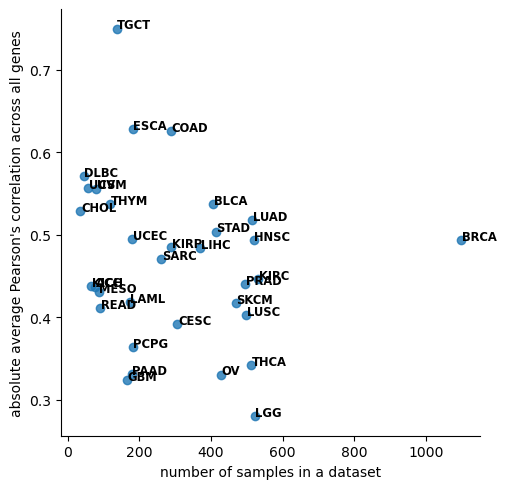

In [10]:
plt.figure(figsize=(5,5))

sns.lmplot(data=stats, 
           x="n_samples",
           y="avg_corr",
           fit_reg=False)#, hue='germ_layer')
for line in range(0,stats.shape[0]):
    if stats.index[line] not in ["PCPG","DLBC","HNSC","TGCT"]:
        plt.text(stats.n_samples[line]+2, stats.avg_corr[line],
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
    else:
        plt.text(stats.n_samples[line]-0, stats.avg_corr[line]-0,
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel("number of samples in a dataset")
plt.ylabel("absolute average Pearson's correlation across all genes")

plt.show()

In [11]:
stats_corr["avg_corr"].min(),stats_corr["avg_corr"].mean(),stats_corr["avg_corr"].max() 

(0.04467365957587847, 0.4371235500758135, 1.0)

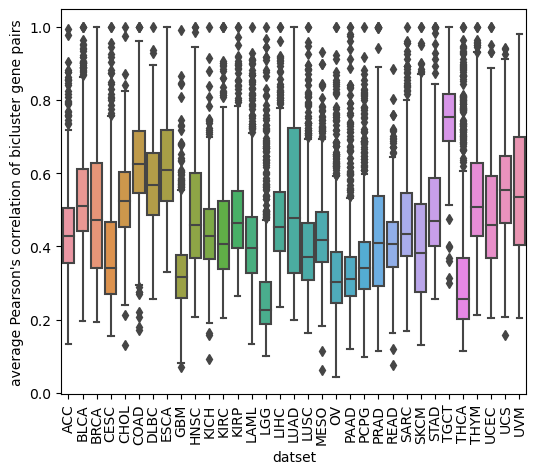

In [12]:
plt.figure(figsize=(6,5))

sns.boxplot(data=stats_corr, 
           x="cancer",
           y="avg_corr")#, hue='germ_layer')
plt.xlabel("datset")
plt.ylabel("average Pearson's correlation of bicluster gene pairs")
plt.xticks(rotation=90)
plt.savefig(bic_dir+"/avg_corrs.svg")
plt.show()

In [13]:
#stats_corr.loc[stats_corr["cancer"]=="BRCA",:].sort_values(by = ["avg_corr"],ascending = [True]).head(60)

# Find similar biclusters in different cancers

* find biclusters significantly overlapping in genes
* find modules in Jaccard similarity matrix
* for each module, extract genes in 50%+ biclusters
* comapre cancer by matched biclusters

In [14]:
from unpast.utils.eval import find_best_matching_biclusters
import numpy as np

In [15]:
bg_gene_names = sorted(passed_ids)
exprs_file = cancer+".exprs.tsv.gz"
exprs = pd.read_csv(exprs_dir+"/"+exprs_file,sep = "\t",index_col=0)
exprs = exprs.loc[bg_gene_names,:]
print("Background:", len(bg_gene_names))

Background: 26296


### pairwise  bicluster similarity by genes

In [16]:
def sim_from_make_consensus_biclusters(biclusters,
                                       run="cancer",
                                       similarity = "genes",
                                       sizes = (exprs.shape[0],0),
                                       p=0.05,
                                       min_n_genes=2):
    runs = sorted(set(biclusters[run].values))
    n_runs = len(runs)
    n_bics = biclusters.shape[0]
    bic_ids = biclusters.index.values
    J_heatmap = pd.DataFrame(np.zeros((n_bics, n_bics)), index=bic_ids, columns=bic_ids)

    # add only best matches to Jaccard similarity matrix
    avg_J_sim = {}
    for i in range(n_runs):
        # bicluster is always the best match of itself,
        # similarity matrix block for output of a biclustering method w. itself is an identity matrix
        bics1 = biclusters.loc[biclusters[run] == runs[i], :]
        J_heatmap.loc[bics1.index.values, bics1.index.values] = np.identity(
            bics1.shape[0]
        )
        avg_J_sim[i] = {i: 1}
        print(runs[i])
        for j in range(n_runs):
            if i != j:
                bics2 = biclusters.loc[biclusters[run] == runs[j], :]
                # find best matches between bics1 and bics2
                bm = find_best_matching_biclusters(
                    bics1,
                    bics2,
                    sizes ,
                    by=similarity,
                    min_g=min_n_genes,
                    adj_pval_thr=p,
                )
                bm = bm.dropna()
                if bm.shape[0] > 0:
                    avg_J_sim[i][j] = np.mean(bm["J"])
                    df = bm.loc[:, ["bm_id", "J"]]
                    for row in df.iterrows():
                        J_heatmap.loc[row[0], row[1]["bm_id"]] += row[1]["J"] / 2
                        J_heatmap.loc[row[1]["bm_id"], row[0]] += row[1]["J"] / 2
    return J_heatmap

biclusters = pd.concat(list(bics.values()))
sim = sim_from_make_consensus_biclusters(biclusters, run="cancer")
matched_bic_ids = list(sim.index[sim.sum(axis=1)>1].values)
sim = sim.loc[matched_bic_ids,matched_bic_ids]
sim.to_csv(bic_dir+"/J_sim_all_biclusters.tsv",sep = "\t",)

sim[sim<0.1] = 0 
matched_bic_ids = list(sim.index[sim.sum(axis=1)>1].values)
sim = sim.loc[matched_bic_ids,matched_bic_ids]
sim.to_csv(bic_dir+"/J_sim_all_biclusters_more0.1.tsv",sep = "\t",)
J_heatmap = 0
sim.shape

ACC
BLCA
BRCA
CESC
CHOL
COAD
DLBC
ESCA
GBM
HNSC
KICH
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
OV
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
TGCT
THCA
THYM
UCEC
UCS
UVM


(6465, 6465)

In [25]:
#sim = pd.read_csv(bic_dir+"/J_sim_all_biclusters_more0.1_old.tsv",sep = "\t",index_col = 0)
#sim.shape

In [26]:
from unpast.utils.method import run_Louvain, zscore
modules, not_clustered, best_cutoff = run_Louvain(sim,
                                                  similarity_cutoffs=[0.33],
                                                  plot= False)

	Running Louvain ...
		modularity: newman
	Louvain runtime: modules detected in 2.03 s.
	modules: 833, not clustered features 1630 
		similarity cutoff: 0.33 modularity: 0.993


### gene families and chr locations (HGNC)

In [27]:
gene_info  = pd.read_csv("../../data/preprocessed_v6/HGNC_gene_info.tsv",sep = "\t",index_col=1)
gene_info = gene_info.loc[:,["Chromosome","Gene group name"]]
gene_info["chrom2"] = gene_info["Chromosome"].apply(lambda x: x.split(".")[0])
gene_info = gene_info.fillna("NA")
add_genes = set(passed_ids).difference(gene_info.index.values)
gene_info = gene_info.T
gene_info.loc[["Chromosome","chrom2"],sorted(add_genes)] = "NA"
gene_info.loc[["Gene group name"],sorted(add_genes)] = "NA"
gene_info = gene_info.T
gene_info["Gene group name"] = gene_info["Gene group name"].apply(lambda x : set([elem for elem in x.split("|") if not elem == "NA"]))
gene_info.head(2)

,Chromosome,Gene group name,chrom2
Approved symbol,,,
A1BG,19q13.43,{Immunoglobulin like domain containing},19q13
A1BG-AS1,19q13.43,{Antisense RNAs},19q13


In [28]:
gene2group = gene_info["Gene group name"].to_dict()
gene2chr = gene_info["Chromosome"].to_dict()
gene2chr2 = gene_info["chrom2"].to_dict()

### Annotating groups of similar biclusters

In [29]:
def f(genes):
    s = set([])
    for g in genes:
        s|= set( [x for x in gene2group[g] if not x == "NA" ])
    return s

pancan = []
for m in modules:
    
    count_genes = {} # in how many cancers a gene is biclustered
    count_cancers = set([])
    for bic in m:
        c = bic.split("_")[0]
        count_cancers.add(c)
        for g in bics[c].loc[bic,"genes"]:
            if g in count_genes.keys():
                count_genes[g].add(c)
            else:
                count_genes[g] = set([c])
                
    count_genes = pd.Series(count_genes).apply(lambda x: len(x)).sort_values()
    passed_genes = count_genes[count_genes>len(count_cancers)/2].index.values

    if len(passed_genes)>0:
        pancan.append({"n_genes":len(passed_genes),"genes":set(passed_genes),
                  "n_cancers":len(count_cancers),"cancers":count_cancers,"biclusters":set(m)})
pancan = pd.DataFrame.from_records(pancan)
pancan['gene_groups'] = pancan["genes"].apply(lambda genes: f(genes))
pancan['loc'] = pancan["genes"].apply(lambda genes: set([gene2chr2[x] for x in genes]).difference(set(["NA"])))
pancan['n_loc'] = pancan['loc'].apply(lambda x: len([elem for elem in x if not elem == ""]))
pancan['n_groups'] = pancan['gene_groups'].apply(lambda x: len([elem for elem in x if not elem == ""]))

pancan = pancan.sort_values(by= ["n_cancers","n_genes"],ascending = [False,False])
print(pancan.shape[0])

833


In [30]:
reccurrent_bics = pancan.loc[pancan["n_loc"]>1,:].loc[pancan["n_groups"]>1,:].loc[pancan["n_cancers"]>=5,:].loc[pancan["n_genes"]>=10,:]
reccurrent_bics 
# 833 communities
# 160 from more than one locus
# 70 of genes from at least two families
# 17 in at least 5 cancers
# 7 with at lest 10 genes in at least 5 cancers

,n_genes,genes,n_cancers,cancers,biclusters,gene_groups,loc,n_loc,n_groups
0,26,"{KDM5D, ZFY, EIF1AY, HSFY3P, TTTY14, PRKY, FAM...",29,"{READ, KICH, LAML, LUSC, SKCM, LIHC, SARC, CHO...","{BLCA_98, KIRC_18, BLCA_327, LUAD_11, LGG_28, ...","{Zinc fingers C2H2-type, Minor histocompatibil...","{Yq11, Yp11}",2,18
26,93,"{IGHV3-72, IGKV2D-30, IGLV1-41, IGHV1-24, IGKV...",22,"{LUSC, SKCM, LIHC, SARC, KIRP, PAAD, GBM, ESCA...","{LUSC_665, ACC_319, SKCM_233, KIRC_379, PRAD_2...","{Immunoglobulin heavy locus at 14q32.33, Immun...","{14q32, 13q14, 22q11, 16p11, 12q15, 1q42, 2p12...",12,8
37,17,"{TRIM53AP, TRIM53BP, PRAMEF14, PRAMEF15, TRIM4...",17,"{CESC, BLCA, TGCT, PRAD, LUSC, OV, SKCM, BRCA,...","{TGCT_133, ESCA_65, PRAD_76, BLCA_178, UCS_90,...","{Ring finger proteins, PRAME family, PRD class...","{19p13, 19q13, 1p36, 11p11, 11q14}",5,5
58,11,"{RNU6-4P, RNU6-6P, RNU6-2, RNU6-3P, RNU6-8, RN...",16,"{CESC, UVM, TGCT, PRAD, LUSC, LAML, READ, SKCM...","{UCS_0, LUSC_4, PCPG_429, LGG_180, CESC_183, T...",{U4/U6 small nuclear ribonucleoprotein particl...,"{14q12, 7q31, 10p13, 2q31, 15q23, 1p36, 3q26, ...",9,5
128,114,"{TRBV30, TRAV8-4, TRAV1-1, TRDV1, CLEC4C, TRAV...",10,"{CESC, BLCA, PRAD, LUSC, SKCM, BRCA, SARC, LUA...","{BLCA_751, SARC_340, LGG_290, LUAD_189, CESC_3...","{Zinc fingers 3CxxC-type, CD molecules, T cell...","{6p21, 3q13, 1q22, 20p13, 19q13, 10q11, 7p14, ...",28,23
259,52,"{CFHR5, SLC22A7, ACSM2B, GC, FGA, APOC3, PRODH...",5,"{CESC, BLCA, PRAD, SKCM, SARC}","{CESC_76, SARC_269, BLCA_276, SKCM_8, PRAD_20}","{Solute carrier family 17, Cystatins, type 3, ...","{10q21, 4q13, 20p12, 2p11, 3q27, 3q26, 11p11, ...",31,24
279,48,"{SNORA45A, SNORA80A, RNY1, SNORD118, SNORD8, R...",5,"{PRAD, OV, THCA, PCPG, LGG}","{THCA_77, PRAD_52, OV_430, PCPG_58, LGG_355}","{Small nucleolar RNAs, C/D box, Variant U1 sma...","{20q11, 1q42, 2p12, 1q25, 2p11, 2q11, 11p15, 1...",32,12


In [31]:
pancan[pancan["genes"].apply(lambda x: "ERBB2" in x)]

,n_genes,genes,n_cancers,cancers,biclusters,gene_groups,loc,n_loc,n_groups
501,4,"{MIEN1, PGAP3, ERBB2, STARD3}",3,"{ESCA, BRCA, STAD}","{STAD_63, BRCA_42, ESCA_231}","{MicroRNA protein coding host genes, CD molecu...",{17q12},1,5


## plotting average z-scores of a recurrent biclusters

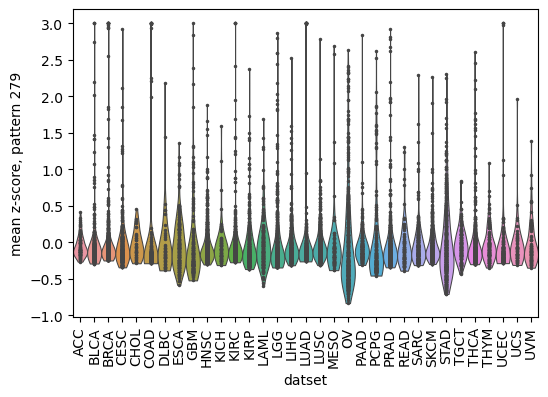

In [50]:
cancers = stats.index.values
#in all cancers
for ndx in [279]:#recurrent_biclusters.index.values:
    genes = sorted(pancan.loc[ndx,"genes"])
    cs = sorted(pancan.loc[ndx,"cancers"])
    data = []
    for cancer in cancers:
        exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t").loc[genes,:]
        e_z_mean = prepare_input_matrix(exprs,ceiling=3).mean()
        df = pd.DataFrame.from_dict({"mean_z":e_z_mean, "pattern":ndx, "cancer":cancer,"detected":cancer in cs})
        data.append(df)
        
    data=pd.concat(data)
    plt.figure(figsize=(6,4))
    sns.violinplot(data=data,x="cancer",y="mean_z",
                   scale ="width", width=1,
                   cut = 0,
                   inner="point",
                   #hue = "detected", dodge=False, palette={True:"red",False:"white"},
                   linewidth =0.75
                  )
    plt.xlabel("datset")
    plt.ylabel("mean z-score, pattern %s"%ndx)
    plt.xticks(rotation=90)
    #plt.savefig(bic_dir+"/avg_corrs.svg")
    plt.show()

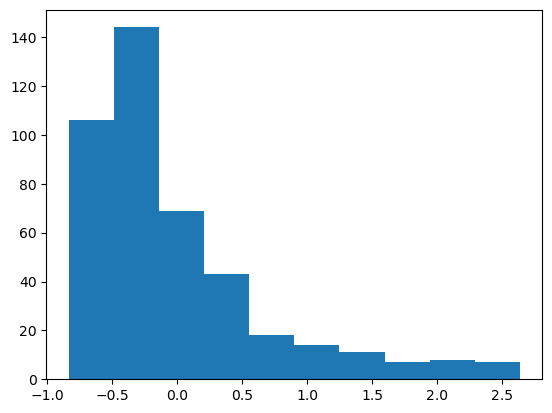

In [51]:
tmp = plt.hist(data.loc[data["cancer"]=="OV","mean_z"])

## heatmaps for recurrent biclusters 

In [52]:
cluster_id = 279
shared_genes = pancan.loc[cluster_id,"genes"]
print("\t".join(sorted(shared_genes)))

HIST1H4A	RN7SKP203	RN7SKP255	RN7SKP71	RN7SL5P	RNA5S9	RNA5SP202	RNU4-1	RNU5A-1	RNU5B-1	RNU5E-1	RNVU1-7	RNY1	RNY3	SCARNA1	SCARNA3	SNORA12	SNORA14B	SNORA16A	SNORA23	SNORA24	SNORA34	SNORA35	SNORA37	SNORA38B	SNORA45A	SNORA49	SNORA54	SNORA55	SNORA5A	SNORA5C	SNORA71A	SNORA71D	SNORA76C	SNORA79	SNORA7A	SNORA7B	SNORA80A	SNORA80B	SNORA84	SNORD10	SNORD118	SNORD15A	SNORD15B	SNORD8	SNORD89	SNORD94	Telomerase-vert


In [53]:
print("\t".join(pancan.loc[cluster_id,"biclusters"]))

THCA_77	PRAD_52	OV_430	PCPG_58	LGG_355


In [54]:
#c1 = set(stats.index.values)
#c2 = set([x.split("_")[0] for x in pancan.loc[cluster_id,"biclusters"]])  
#c1.difference(c2)

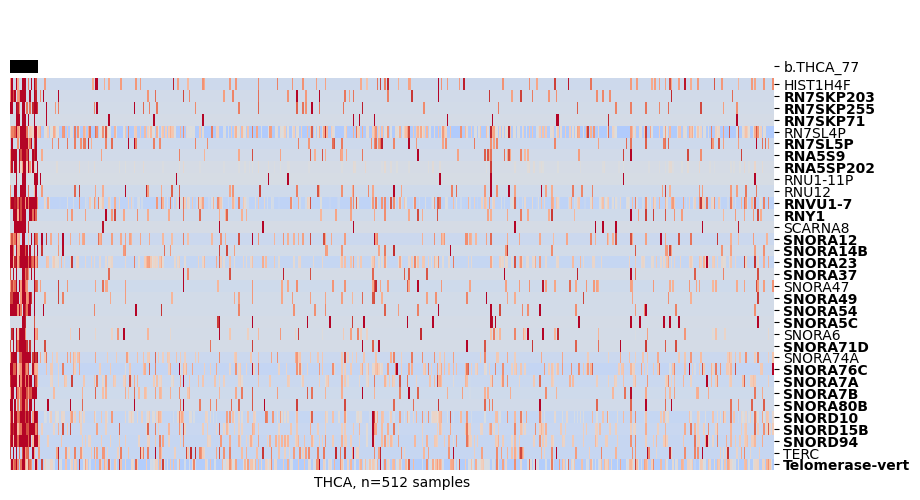

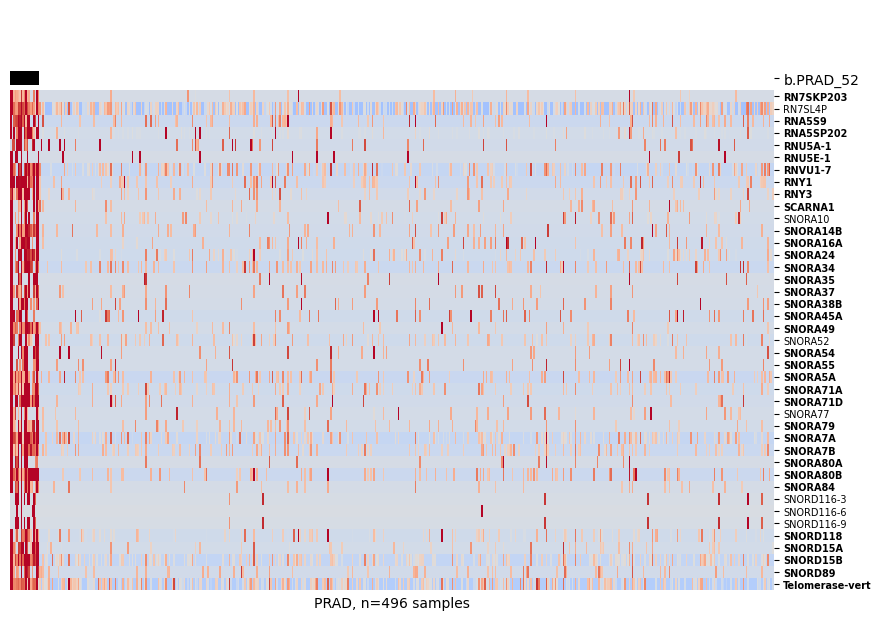

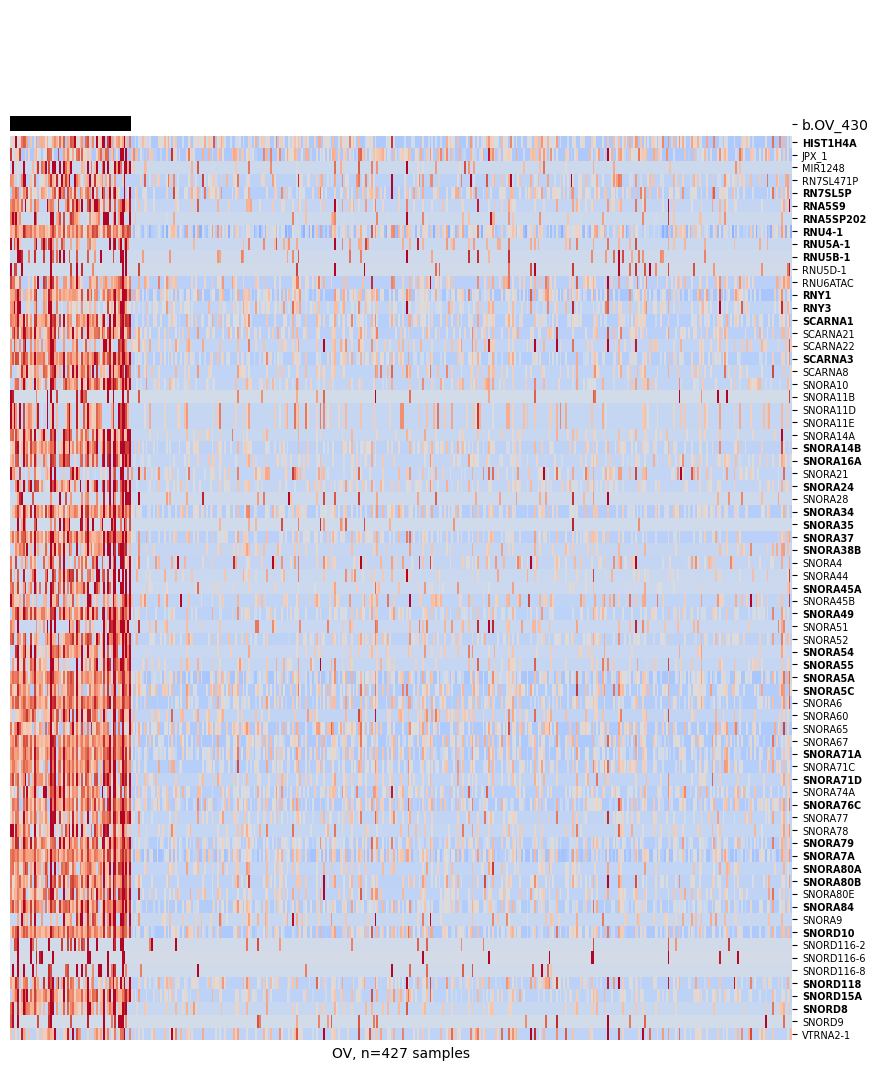

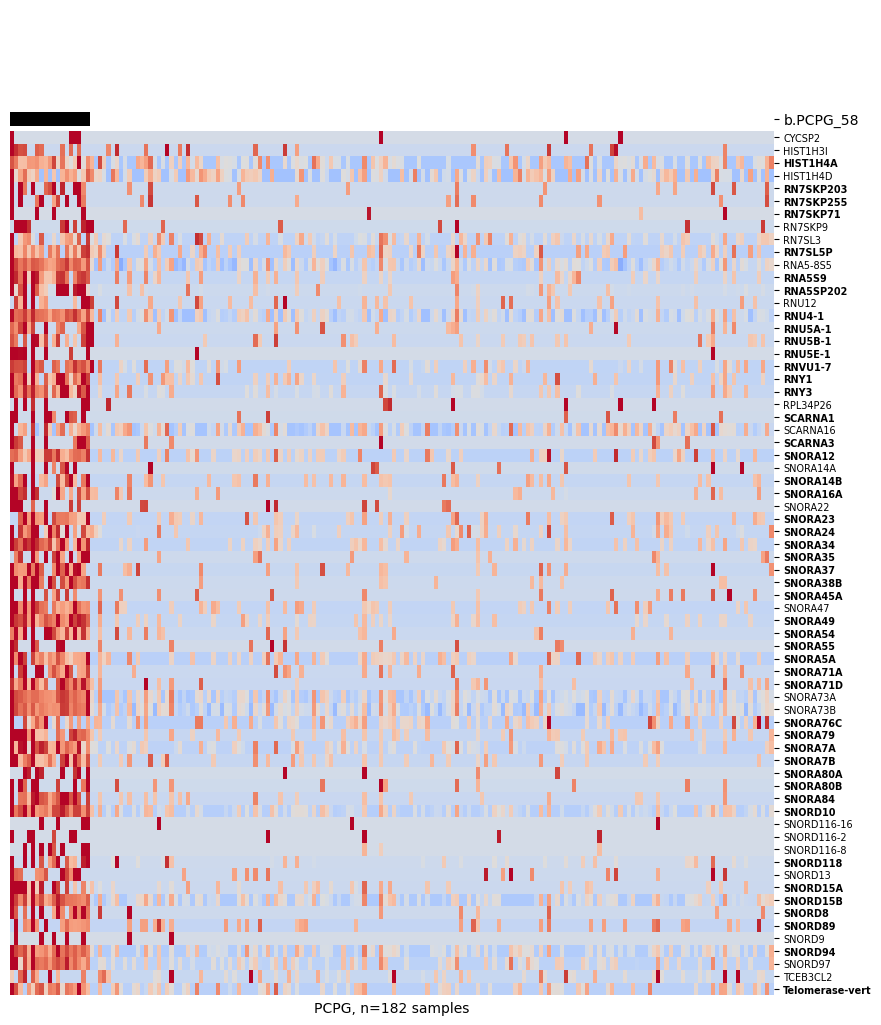

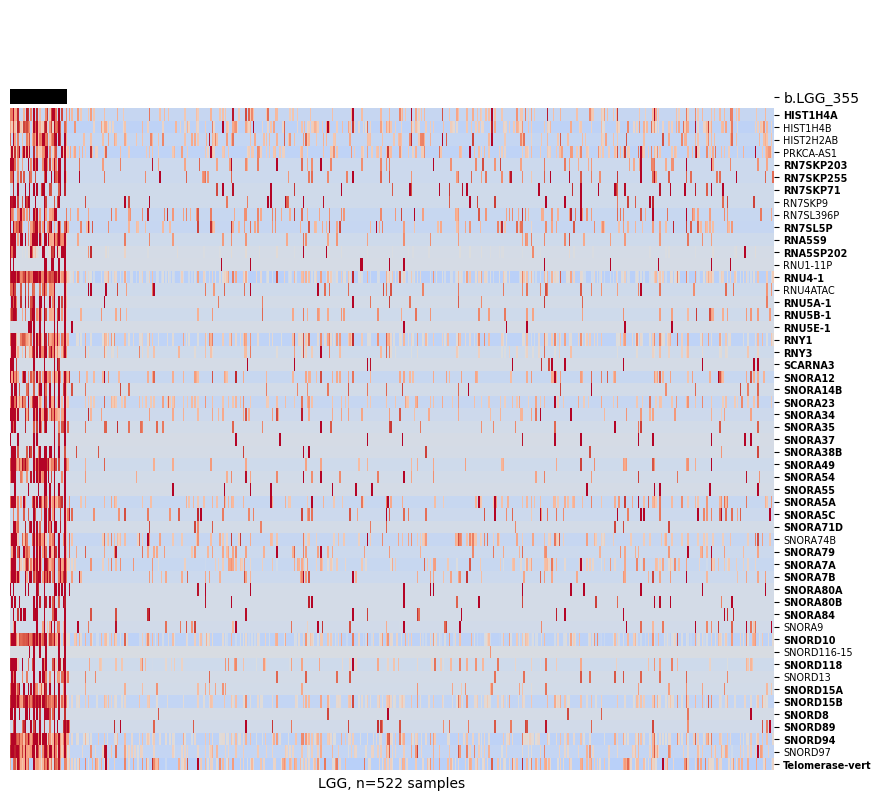

In [55]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import prepare_input_matrix

for bic_id in pancan.loc[cluster_id,"biclusters"]:
    i = [bic_id]
    cancer = bic_id.split("_")[0]
    exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
    exprs_z = prepare_input_matrix(exprs)
    bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
    biclusters = read_bic_table(bic_file)
    b = biclusters.loc[i,:]
    # fig. heights
    h = min(max(0.15*(b["n_genes"].sum()),3),20)
    row_labels = True
    if h>=20:
        row_labels = False
    
    tmp = draw_heatmap2(exprs_z ,b,
                  bicluster_colors= "black",
                  figsize = (10,h), 
                  dendrogram_ratio=(0.1,0.1),
                  colors_ratio=(0.0, 0.15/h),
                  bic_prefix = "b.",
                  xlabel='%s, n=%s samples'%(cancer,exprs.shape[1]),
                  highlight_row_labels=shared_genes,
                  no_cbar=True,
                  col_labels = False,
                  row_labels = row_labels,
                  no_row_colors = True,
                  cluster_rows=False
                 )
    if h>5 and h<20:
        tmp[0].ax_heatmap.set_yticklabels(tmp[0].ax_heatmap.get_yticklabels(),fontdict={"size":7})

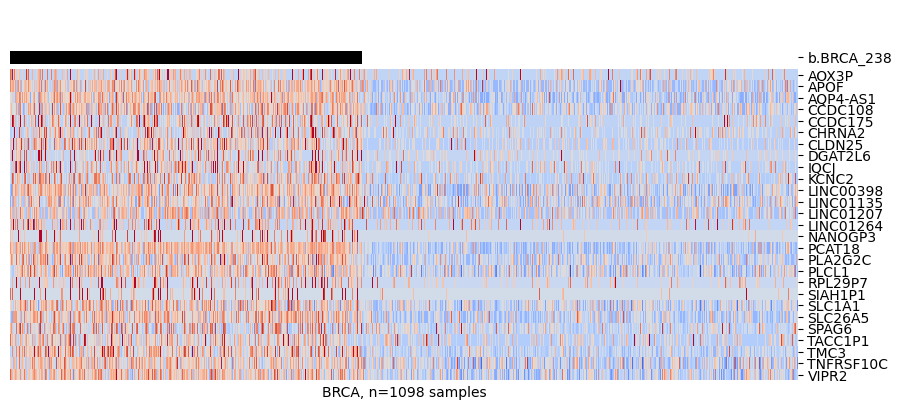

In [38]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import prepare_input_matrix

i = ["BRCA_238"]  
cancer = "BRCA"

exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
exprs_z = prepare_input_matrix(exprs)
bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
biclusters = read_bic_table(bic_file)
b = biclusters.loc[i,:]

h = min(max(0.15*(b["n_genes"].sum()),3),20)
row_labels = True
if h>=20:
    row_labels = False

tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors= "black",
              figsize = (10,h), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.0, 0.15/h),
              bic_prefix = "b.",
              xlabel='%s, n=%s samples'%(cancer,exprs.shape[1]),
              #highlight_row_labels=shared_genes,
              no_cbar=True,
              col_labels = False,
              row_labels = row_labels,
              no_row_colors = True,
              cluster_rows=False
             )
if h>5 and h<20:
    tmp[0].ax_heatmap.set_yticklabels(tmp[0].ax_heatmap.get_yticklabels(),fontdict={"size":7})

# Gene Set Over-representaton Analysis

In [39]:
import gseapy
#help(gseapy.get_library)
#help(gseapy.enrich)

In [40]:
list(reccurrent_bics.index.values)

[0, 26, 37, 58, 128, 259, 279]

In [41]:
bg_gene_names = sorted(passed_ids)
print("Background:", len(bg_gene_names))

Background: 26296


## EnrichR gene sets
(slow)

In [46]:
names = gseapy.get_library_name()
# names
gset_db_names = ['GO_Molecular_Function_2023','GO_Biological_Process_2023',
            'Reactome_Pathways_2024','KEGG_2021_Human','WikiPathways_2024_Human',
            'CellMarker_2024','Descartes_Cell_Types_and_Tissue_2021','Tabula_Sapiens']

gset_db_names = ['GO_Molecular_Function_2025', 
            'GO_Biological_Process_2025',
            'Reactome_Pathways_2024',
            'KEGG_2021_Human',
            'CORUM',
            'GTEx_Tissues_V8_2023',
            'CellMarker_2024',
            'Descartes_Cell_Types_and_Tissue_2021',
            'Tabula_Sapiens',
            'The_Kinase_Library_2024',
            'WikiPathways_2024_Human',
            'miRTarBase_2017','lncHUB_lncRNA_Co-Expression',
            'TF-LOF_Expression_from_GEO','TF_Perturbations_Followed_by_Expression',
            'TRANSFAC_and_JASPAR_PWMs','TRRUST_Transcription_Factors_2019',
            'Rummagene_kinases', 'Rummagene_signatures','Rummagene_transcription_factors',
            'RNAseq_Automatic_GEO_Signatures_Human_Down','RNAseq_Automatic_GEO_Signatures_Human_Up',
            'MSigDB_Hallmark_2020',
            'Kinase_Perturbations_from_GEO_down',
             'Kinase_Perturbations_from_GEO_up',
             'L1000_Kinase_and_GPCR_Perturbations_down',
             'L1000_Kinase_and_GPCR_Perturbations_up',
             'LINCS_L1000_CRISPR_KO_Consensus_Sigs',
             'LINCS_L1000_Chem_Pert_Consensus_Sigs',
             'LINCS_L1000_Chem_Pert_down',
             'LINCS_L1000_Chem_Pert_up',
             'LINCS_L1000_Ligand_Perturbations_down',
             'LINCS_L1000_Ligand_Perturbations_up',
             'Ligand_Perturbations_from_GEO_down',
             'Ligand_Perturbations_from_GEO_up',
             'Gene_Perturbations_from_GEO_down',
             'Gene_Perturbations_from_GEO_up',
             'DrugMatrix',
             'Drug_Perturbations_from_GEO_2014',
             'Drug_Perturbations_from_GEO_down',
             'Drug_Perturbations_from_GEO_up',
             'DGIdb_Drug_Targets_2024',
             'DSigDB'
]


print("Background:", len(bg_gene_names))

gset_db_list  = []
## download databases, extract datasets, overlap with background
for db_name in gset_db_names:
    gset_db = gseapy.get_library(name=db_name,
                                 organism ='Human',
                                 min_size = 2, 
                                 #max_size = 1000,
                                 gene_list= bg_gene_names)
    
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs =  sorted(set(gset).intersection(set(bg_gene_names)))
        if len(gset_db)>=2:
            gset_db[gs] = gset_exprs
    print(db_name, len(gset_db.keys()))
    
    gset_db_list.append(gset_db)

Background: 26296
GO_Molecular_Function_2025 1174
GO_Biological_Process_2025 5340
Reactome_Pathways_2024 2081
KEGG_2021_Human 320
CORUM 1555
GTEx_Tissues_V8_2023 511
CellMarker_2024 1692
Descartes_Cell_Types_and_Tissue_2021 172
Tabula_Sapiens 469
The_Kinase_Library_2024 392
WikiPathways_2024_Human 829
miRTarBase_2017 3240
lncHUB_lncRNA_Co-Expression 3729
TF-LOF_Expression_from_GEO 251
TF_Perturbations_Followed_by_Expression 1958
TRANSFAC_and_JASPAR_PWMs 288
TRRUST_Transcription_Factors_2019 568
Rummagene_kinases 3771
Rummagene_signatures 10774
Rummagene_transcription_factors 7172
RNAseq_Automatic_GEO_Signatures_Human_Down 4269
RNAseq_Automatic_GEO_Signatures_Human_Up 4269
MSigDB_Hallmark_2020 50
Kinase_Perturbations_from_GEO_down 285
Kinase_Perturbations_from_GEO_up 285
L1000_Kinase_and_GPCR_Perturbations_down 3644
L1000_Kinase_and_GPCR_Perturbations_up 3644
LINCS_L1000_CRISPR_KO_Consensus_Sigs 10424
LINCS_L1000_Chem_Pert_Consensus_Sigs 10850
LINCS_L1000_Chem_Pert_down 33064
LINCS_L100

In [47]:
#output_file = bic_dir+'recurrent_biclusters_GSOA_v2_17patterns_detailed.xlsx'
output_file = bic_dir+'recurrent_biclusters_GSOA_EnrichR_7patterns.xlsx'

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    # save recurrent biclusters and GSOA results to Excel
    rb = reccurrent_bics.loc[:,:].copy()
    rb.index = ["bic."+str(x) for x in rb.index]
    for col in ['gene_groups',"loc","genes","cancers","biclusters"]:
        rb[col] = rb[col].apply(lambda x: " ".join(sorted([elem for elem in x if not elem == ""])))
    rb.to_excel(writer, sheet_name="recurrent biclusters")
    # save recurrent biclusters and GSOA results to Excel
    # keep only signif. overlaps of size more than one
    for bic_id in list(reccurrent_bics.index.values):
        genes = sorted(pancan.loc[bic_id,"genes"])
        gp_output = gseapy.enrich(gene_list=genes,
                                   gene_sets=gset_db_list,
                                   background=bg_gene_names,
                                   outdir=None,
                                   no_plot=True
                                  )
        res = gp_output.results
        res["shared_genes"] = res["Genes"].apply(lambda x: set(x.split(";")))
        res["overlap"] = res["shared_genes"].apply(lambda x: len(x))
        res["shared_genes"] = res["shared_genes"].apply(lambda x : " ".join(sorted(x)))
        res["gene_set_collection"] = res["Gene_set"].apply(lambda x: gset_db_names[int(x.replace("gs_ind_",""))])
        res["db_gene_set_size"] = res["Overlap"].apply(lambda x: int(x.split("/")[1]))
        res["gene_set"] = res["Term"]
        cols = ["gene_set_collection","gene_set","overlap","shared_genes","db_gene_set_size"]
        cols2 = ["P-value","Adjusted P-value","Odds Ratio","Combined Score"]
        res = res.loc[res["overlap"]>1,cols+cols2]
        res = res.loc[res["Adjusted P-value"]<0.05,:]
        
        print("bic.%s, %s signif. gene set overlaps"%(bic_id,res.shape[0]))
        if res.shape[0]>0:
            res_condensed = []
            for db_name in set(res["gene_set_collection"].values):
                df = res.loc[res["gene_set_collection"]==db_name,:]
                for sg in set(df["shared_genes"].values):
                    # store only one hit per DB, with lowest p-val
                    res_condensed.append(df.loc[df["shared_genes"]==sg,:].sort_values("Adjusted P-value").head(1))
            res_condensed = pd.concat(res_condensed)
            res_condensed = res_condensed.sort_values(by = ["Combined Score","shared_genes"], ascending=[False,True])
        else:
            res_condensed = res.loc[:,:].copy()
        res_condensed.to_excel(writer, sheet_name="bic."+str(bic_id), index=False)

bic.0, 6942 signif. gene set overlaps
bic.26, 93 signif. gene set overlaps
bic.37, 127 signif. gene set overlaps
bic.58, 2 signif. gene set overlaps
bic.128, 36 signif. gene set overlaps
bic.259, 9946 signif. gene set overlaps
bic.279, 111 signif. gene set overlaps


## MSigDB

In [44]:
from gseapy import Msigdb
msig = Msigdb()
#msig.list_dbver()
dbver = "2024.1.Hs"
gset_db_names = msig.list_category(dbver=dbver)
gset_db_names = ["h.all",
                 #"c1.all",
                 "c2.all",
                 "c3.mir","c3.tft",
                 "c4.all",
                 "c5.go.mf","c5.go.bp","c5.go.cc","c5.hpo",
                 "c6.all",
                 "c7.all",
                 "c8.all"]

print("Background:", len(bg_gene_names))
gset_db_list = []
for db_name in gset_db_names:
    gset_db = msig.get_gmt(category=db_name, dbver=dbver)
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs =  sorted(set(gset).intersection(set(bg_gene_names)))
        if len(gset_db)>=2:
            gset_db[gs] = gset_exprs
    print(db_name, len(gset_db.keys()))
    gset_db_list.append(gset_db)

Background: 26296
h.all 50
c2.all 7411
c3.mir 2598
c3.tft 1115
c4.all 1006
c5.go.mf 1820
c5.go.bp 7608
c5.go.cc 1026
c5.hpo 5653
c6.all 189
c7.all 5219
c8.all 840


In [45]:
#output_file = bic_dir+'recurrent_biclusters_GSOA_MSigDB_17patterns.xlsx'
output_file = bic_dir+'recurrent_biclusters_GSOA_MSigDB_7patterns.xlsx'

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    # save recurrent biclusters and GSOA results to Excel
    rb = reccurrent_bics.loc[:,:].copy()
    rb.index = ["bic."+str(x) for x in rb.index]
    for col in ['gene_groups',"loc","genes","cancers","biclusters"]:
        rb[col] = rb[col].apply(lambda x: " ".join(sorted([elem for elem in x if not elem == ""])))
    rb.to_excel(writer, sheet_name="recurrent biclusters")
    # save recurrent biclusters and GSOA results to Excel
    # keep only signif. overlaps of size more than one
    for bic_id in list(reccurrent_bics.index.values):
        genes = sorted(pancan.loc[bic_id,"genes"])
        gp_output = gseapy.enrich(gene_list=genes,
                                   gene_sets=gset_db_list,
                                   background=bg_gene_names,
                                   #cutoff = 0.05,
                                   outdir=None,
                                   no_plot=True
                                  )
        res = gp_output.results
        res["shared_genes"] = res["Genes"].apply(lambda x: set(x.split(";")))
        res["overlap"] = res["shared_genes"].apply(lambda x: len(x))
        res["shared_genes"] = res["shared_genes"].apply(lambda x : " ".join(sorted(x)))
        res["gene_set_collection"] = res["Gene_set"].apply(lambda x: gset_db_names[int(x.replace("gs_ind_",""))])
        res["db_gene_set_size"] = res["Overlap"].apply(lambda x: int(x.split("/")[1]))
        res["gene_set"] = res["Term"]
        cols = ["gene_set_collection","gene_set","overlap","shared_genes","db_gene_set_size"]
        cols2 = ["P-value","Adjusted P-value","Odds Ratio","Combined Score"]
        res = res.loc[res["overlap"]>1,cols+cols2]
        res = res.loc[res["Adjusted P-value"]<0.05,:]
        
        print("bic.%s, %s signif. gene set overlaps"%(bic_id,res.shape[0]))
        if res.shape[0]>0:
            
            res_condensed = []
            for db_name in set(res["gene_set_collection"].values):
                df = res.loc[res["gene_set_collection"]==db_name,:]
                for sg in set(df["shared_genes"].values):
                    # store only one hit per DB, with lowest p-val
                    res_condensed.append(df.loc[df["shared_genes"]==sg,:].sort_values("Adjusted P-value").head(1))
            res_condensed = pd.concat(res_condensed)
            res_condensed = res_condensed.sort_values(by = ["Combined Score","shared_genes"], ascending=[False,True])
        else:
            res_condensed = res.loc[:,:].copy()
        res_condensed.to_excel(writer, sheet_name="bic."+str(bic_id), index=False)

bic.0, 42 signif. gene set overlaps
bic.26, 67 signif. gene set overlaps
bic.37, 52 signif. gene set overlaps
bic.58, 32 signif. gene set overlaps
bic.128, 19 signif. gene set overlaps
bic.259, 827 signif. gene set overlaps
bic.279, 33 signif. gene set overlaps


### cancer similarity

In [48]:
cancers = stats.index.values
color_dict = {}
for c in cancers:
    if c in ento:
        color_dict[c]="green"
    elif c in ecto:
        color_dict[c] = "yellow"
    elif c in meso:
        color_dict[c] = "red"
    else:
        color_dict[c] = "grey"
color_dict = pd.DataFrame.from_dict({"germ layer":color_dict})
pangyn = ["OV","UCEC","CESC","UCS","BRCA"]

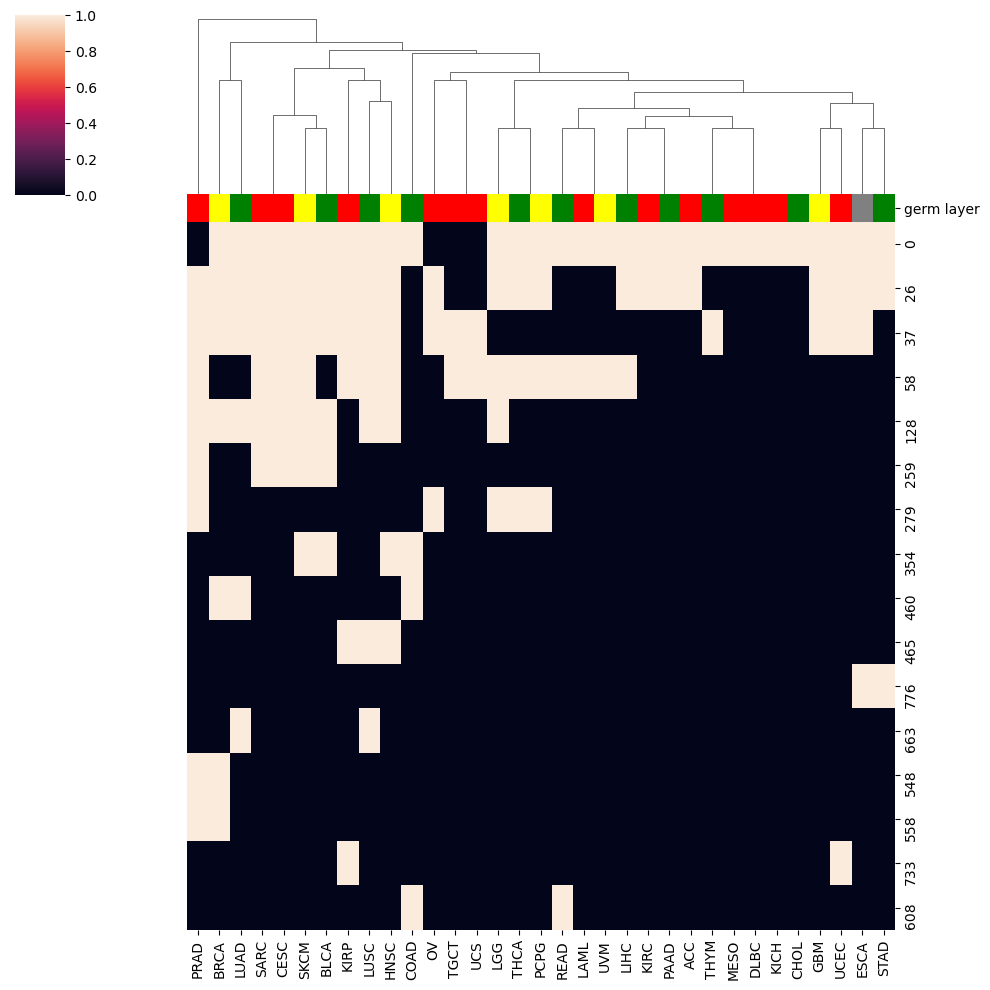

In [49]:
cancer_sim = {}
x = pancan.loc[pancan["n_groups"]>1,:].loc[pancan["n_loc"]>1,:].loc[pancan["n_genes"]>=10,:]

for row in x.iterrows():
    m = row[0]
    c = row[1]["cancers"]
    cancer_sim[m] = dict(zip(c,np.ones(len(c))))
cancer_sim = pd.DataFrame.from_dict(cancer_sim).T
cancer_sim = cancer_sim.fillna(0)
sns.clustermap(cancer_sim ,annot = False,figsize=(10,10), 
               col_colors=color_dict,
               row_cluster = False)